In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint

### Read data

In [60]:

# Loda data
target = pd.read_csv('../data/processed/properties.csv')
features = pd.read_csv('../data/processed/features.csv')

# Merge data
df = pd.merge(target, features, on='Period')

# Convert 'Period' column to datetime format
df['Period'] = pd.to_datetime(df['Period'])


In [61]:

# Exclude 'Period'
numerical_columns = df.columns.difference(['Period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'Period' column
df = df.sort_values(by='Period')

# Display the first few rows and info to confirm changes
print(df.head())
print(df.info())


      Period  num_nodes  num_edges   density  clustering  assortativity  \
0 2010-01-01  -1.907728  -2.123956 -0.662045   -1.736416       0.897781   
1 2010-02-01  -0.812829  -2.025574 -1.541808    0.673488      -0.766521   
2 2010-03-01  -1.086554  -1.189334 -0.333355    1.536279      -0.633031   
3 2010-04-01  -1.360279  -1.907517 -0.913957   -1.713061      -0.709437   
4 2010-05-01  -2.181453  -1.651725  0.169031    1.351597      -0.365774   

   shortest_path       TPU       GPR  CPTOTSAXN  ...  DXGSRMRCHSACD  \
0       1.708130 -0.704058 -0.197764  -1.426643  ...      -1.629180   
1       0.961073 -0.811993 -0.573908  -1.417138  ...      -1.564621   
2      -0.242651 -0.626296 -0.802887  -1.407470  ...      -1.466508   
3       1.308652 -0.684992 -0.295457  -1.395858  ...      -1.446469   
4      -0.639831 -0.762968 -0.288626  -1.387176  ...      -1.517224   

   DMGSRMRCHSACD  IPTOTSAKD    IMPCOV      NEER      REER  RETSALESSA  \
0      -1.734612  -1.962292 -0.116903 -0.682534 -

### Uncertainty measurement

In [62]:

# Define the target columns
target_columns = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Copy the original DataFrame to avoid modifying the original data
lag1_df = df.copy()
lag2_df = df.copy()
lag3_df = df.copy()

# Shift target columns by 1, 2, and 3 periods in respective lag DataFrames
for column in target_columns:
    lag1_df[f'{column}'] = lag1_df[column].shift(1)
    lag2_df[f'{column}'] = lag2_df[column].shift(2)
    lag3_df[f'{column}'] = lag3_df[column].shift(3)

# Shift the Period column backward by 1, 2, and 3 months
lag1_df['Period'] = lag1_df['Period'] - pd.DateOffset(months=1)
lag2_df['Period'] = lag2_df['Period'] - pd.DateOffset(months=2)
lag3_df['Period'] = lag3_df['Period'] - pd.DateOffset(months=3)

# Drop rows with NaN values in lag DataFrames
lag1_df = lag1_df.dropna()
lag2_df = lag2_df.dropna()
lag3_df = lag3_df.dropna()


In [63]:

# Function to perform Random Search Cross-Validation
def perform_random_search_cv(X_train, y_train, random_state=42):
    param_dist = {
        'n_estimators': randint(10, 100),
        'max_depth': [None] + list(np.arange(3, 20)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    # Ensure the RandomForestRegressor has a random_state set for reproducibility
    rf_model = RandomForestRegressor(random_state=random_state)
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Set the random_state in RandomizedSearchCV for reproducibility
    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=random_state
    )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    return random_search.best_estimator_

# Function to calculate Mean Squared Error per period
def calculate_mse_per_period(df, target_column):
    features = df.columns[7:]  # Exclude 'Period' and target columns
    target = target_column

    # Split the dataset into train and test sets based on time
    train_size = int(len(df) * 0.8)
    train_set, test_set = df[:train_size], df[train_size:]

    # Perform cross-validation and random search for hyperparameter tuning on the training set
    best_model = perform_random_search_cv(train_set[features], train_set[target])

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(test_set[features])
    overall_test_mse = mean_squared_error(test_set[target], test_predictions)
    print(f'Overall Test Set Mean Squared Error for {target_column}: {overall_test_mse}')

    # Use the best model to predict on the entire dataset
    full_dataset_predictions = best_model.predict(df[features])

    # Add the predicted values to the DataFrame
    df[f'predicted_{target_column}'] = full_dataset_predictions

    # Calculate MSE for each period
    mse_per_period = df.groupby('Period').apply(lambda group: mean_squared_error(group[target], group[f'predicted_{target_column}'])).reset_index()
    mse_per_period.columns = ['Period', f'mse_{df}']
    
    return mse_per_period


In [64]:

# List of columns to iterate through
columns_to_calculate_mse = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Dictionary to store the calculated MSE DataFrames for each column
mse_per_column_dict = {}

# Assuming lag1_df, lag3_df, lag6_df are your lag DataFrames
for column in columns_to_calculate_mse:
    lag1_mse = calculate_mse_per_period(lag1_df, target_column=column)
    lag2_mse = calculate_mse_per_period(lag2_df, target_column=column)
    lag3_mse = calculate_mse_per_period(lag3_df, target_column=column)

    # Merge the MSE DataFrames on the 'period' column
    merged_mse_df = lag1_mse.merge(lag2_mse, on='Period').merge(lag3_mse, on='Period')

    # Rename the columns to include the column name and lag
    merged_mse_df.columns = ['Period', f'mse_lag1_{column}', f'mse_lag2_{column}', f'mse_lag3_{column}']

    # Store the MSE DataFrame for the current column in the dictionary
    mse_per_column_dict[column] = merged_mse_df

# Create separate DataFrames for each lag
lag1_mse = pd.concat([mse_df[f'mse_lag1_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag2_mse = pd.concat([mse_df[f'mse_lag2_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag3_mse = pd.concat([mse_df[f'mse_lag3_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)

# Include the 'period' column in the resulting DataFrames
lag1_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])
lag2_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])
lag3_mse.insert(0, 'Period', mse_per_column_dict[columns_to_calculate_mse[0]]['Period'])


Best Parameters: {'bootstrap': True, 'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 71}
Overall Test Set Mean Squared Error for num_nodes: 0.8426922007367628
Best Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 87}
Overall Test Set Mean Squared Error for num_nodes: 0.8980024066741636
Best Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 87}
Overall Test Set Mean Squared Error for num_nodes: 1.0736548649449313
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_edges: 0.29617819742211715
Best Parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 48}
Overall Test Set Mean Squared Error for num_edges: 0.3743487726108578
Best Parameters: {'bootstrap': True, 'max_dept

In [65]:

# Display the first few rows for verification
print("Lag 1 DataFrame:")
print(lag1_mse.head())

print("Lag 2 DataFrame:")
print(lag2_mse.head())

print("Lag 3 DataFrame:")
print(lag3_mse.head())


Lag 1 DataFrame:
      Period  mse_lag1_num_nodes  mse_lag1_num_edges  mse_lag1_density  \
0 2010-01-01            0.727651            0.009343          0.023102   
1 2010-02-01            0.062619            0.006866          0.096702   
2 2010-03-01            0.000833            0.073470          0.076178   
3 2010-04-01            0.048719            0.000022          0.002782   
4 2010-05-01            0.678025            0.000764          0.251749   

   mse_lag1_clustering  mse_lag1_assortativity  mse_lag1_shortest_path  
0             1.355422                1.333437                0.159844  
1             0.527170                0.016641                0.213016  
2             1.329008                0.020227                0.024917  
3             0.888309                0.063508                0.014446  
4             0.981629                0.006163                0.235331  
Lag 2 DataFrame:
      Period  mse_lag2_num_nodes  mse_lag2_num_edges  mse_lag2_density  \
0 2010-01

In [66]:

def calculate_uncertainty_metrics(mse_df):
    """
    Calculate uncertainty metrics by averaging the MSE values across different lagged predictions.

    Parameters:
    mse_df (DataFrame): A DataFrame containing MSE values for different lagged predictions.

    Returns:
    DataFrame: A DataFrame containing the 'Period' and the calculated 'uncertainty'.
    """
    
    # Calculate 'uncertainty' as the average of the MSE columns (excluding 'Period')
    mse_df['uncertainty'] = mse_df.iloc[:, 1:].mean(axis=1)
    
    # Keep only the 'Period' and 'uncertainty' columns
    uncertainties = mse_df[['Period', 'uncertainty']]
    
    return uncertainties


In [67]:

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(lag1_mse)
uncertainties_2 = calculate_uncertainty_metrics(lag2_mse)
uncertainties_3 = calculate_uncertainty_metrics(lag3_mse)

# Display the first few rows for verification
print("Lag 1 Uncertainty DataFrame: ")
print(uncertainties_1.head())

print("Lag 2 Uncertainty DataFrame: ")
print(uncertainties_2.head())

print("Lag 2 Uncertainty DataFrame: ")
print(uncertainties_3.head())


Lag 1 Uncertainty DataFrame: 
      Period  uncertainty
0 2010-01-01     0.601467
1 2010-02-01     0.153836
2 2010-03-01     0.254106
3 2010-04-01     0.169631
4 2010-05-01     0.358944
Lag 2 Uncertainty DataFrame: 
      Period  uncertainty
0 2010-01-01     0.407535
1 2010-02-01     0.186099
2 2010-03-01     0.066916
3 2010-04-01     0.060072
4 2010-05-01     0.434010
Lag 2 Uncertainty DataFrame: 
      Period  uncertainty
0 2010-01-01     0.266900
1 2010-02-01     0.111188
2 2010-03-01     0.082563
3 2010-04-01     0.099428
4 2010-05-01     0.423945


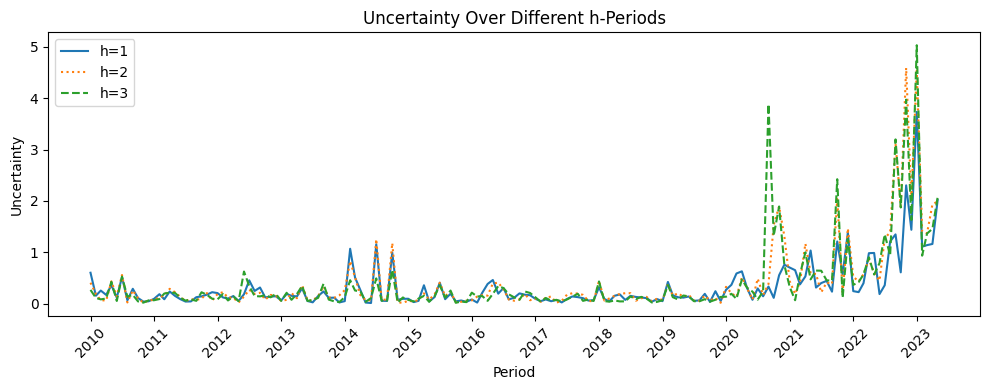

In [68]:

#Plot uncertainty
plt.figure(figsize=(10, 4))
plt.plot(uncertainties_1['Period'], uncertainties_1['uncertainty'], label='h=1', linestyle='-')
plt.plot(uncertainties_2['Period'], uncertainties_2['uncertainty'], label='h=2', linestyle=':')
plt.plot(uncertainties_3['Period'], uncertainties_3['uncertainty'], label='h=3', linestyle='--')

# Set the title and labels
plt.title('Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Uncertainty')

# Adding a legend
plt.legend()

# Improve the x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate x-labels for better readability
plt.xticks(rotation=45)

# Ensure the plot layout is tight
plt.tight_layout()

# Show the plot
plt.show()


In [69]:
# Save to csv
uncertainties_1.to_csv('../data/processed/uncertainty_index.csv', index=False, encoding='utf')